NOTE: I know this is a very late submission, so no feedback is expected.

# Model Prep Challenge

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

1. First, load the dataset.

2. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

3. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization

### 1. First, load the dataset.

In [1]:
%load_ext nb_black

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings("ignore")

postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "lifeexpectancy"
table_name = "lifeexpectancy"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

lifeex_df = pd.read_sql_query("select * from lifeexpectancy", con=engine)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

### 2. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [2]:
lifeex_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


<IPython.core.display.Javascript object>

In [3]:
lifeex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

<IPython.core.display.Javascript object>

All data types seem to be reasonable. All columns that are numbers are either float or int types, and categorical are objects.  But let's clean up these column names and get rid of the weird leading/trailing spaces and mixed cases...

In [4]:
old_cols = list(lifeex_df.columns)
new_cols = []
for old_col in old_cols:
    new_cols.append(old_col.strip().lower())

mapper = {old_cols[i]: new_cols[i] for i in range(len(old_cols))}

lifeex_df_renamed = lifeex_df.rename(columns=mapper)

lifeex_df = lifeex_df_renamed

<IPython.core.display.Javascript object>

Because I suspect 'status' could profoundly impact life expectancy, let's turn encode this variable for future analysis.  First, what are the possible values?

In [5]:
lifeex_df["status"].value_counts()

Developing    2426
Developed      512
Name: status, dtype: int64

<IPython.core.display.Javascript object>

Let's turn the "Status" feature into a 1 if it's developed and a 0 if it's developing.

In [6]:
def is_devel(devel_string):
    if devel_string == "Developed":
        return 1
    else:
        return 0


lifeex_df["is_devel"] = lifeex_df["status"].apply(is_devel)

# drop old status feature
lifeex_df = lifeex_df.drop(columns=["status"])

<IPython.core.display.Javascript object>

Next, let's see what fraction of each feature are null...

In [7]:
lifeex_df.isna().mean().sort_values(ascending=False)

population                         0.221920
hepatitis b                        0.188223
gdp                                0.152485
total expenditure                  0.076923
alcohol                            0.066031
income composition of resources    0.056841
schooling                          0.055480
thinness 5-9 years                 0.011572
thinness  1-19 years               0.011572
bmi                                0.011572
diphtheria                         0.006467
polio                              0.006467
life expectancy                    0.003404
adult mortality                    0.003404
infant deaths                      0.000000
year                               0.000000
is_devel                           0.000000
under-five deaths                  0.000000
percentage expenditure             0.000000
measles                            0.000000
hiv/aids                           0.000000
country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

Right away, I see that some data is missing for life expectancy.  This would be a crucial piece of info for our investigation, because it is our target.  Let's see how this missingness is distributed and whether we can imputate...

In [8]:
lifeex_df.loc[lifeex_df["life expectancy"].isna(), "country"]

624              Cook Islands
769                  Dominica
1651         Marshall Islands
1716                   Monaco
1813                    Nauru
1910                     Niue
1959                    Palau
2168    Saint Kitts and Nevis
2217               San Marino
2713                   Tuvalu
Name: country, dtype: object

<IPython.core.display.Javascript object>

Because these countries all have just one row of data, and that row doesn't contain our target, we should exclude them from analysis...

In [9]:
lifeex_df = lifeex_df.dropna(subset=["life expectancy"])

<IPython.core.display.Javascript object>

Next, let's pare down our dataset by doing a quick-and-dirty investigation of which columns are correlated with our target.  We can then throw out whichever are not.

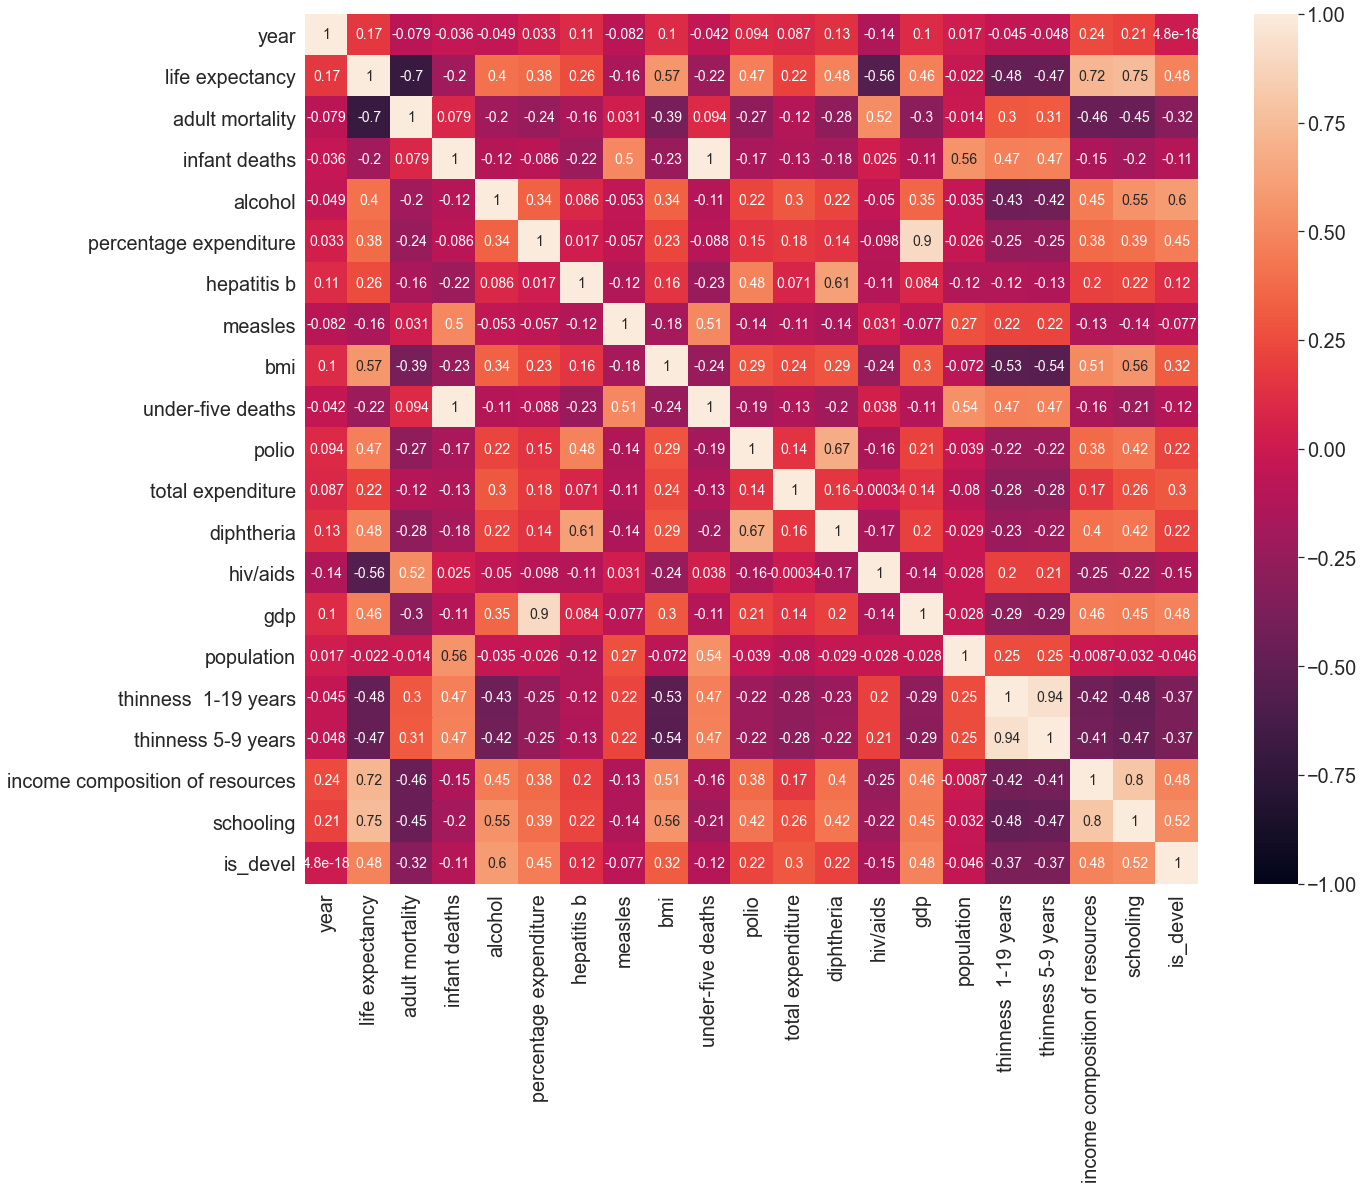

<IPython.core.display.Javascript object>

In [10]:
plt.figure(figsize=(20, 16))
sns.set(font_scale=1.8)
sns.heatmap(
    lifeex_df.corr(), annot=True, annot_kws={"size": 14}, vmin=-1, vmax=1,
)
plt.show()

From above, we see that life expectancy does NOT appear to be strongly correlated with population, total expenditure, measles, hep B, infant deaths, under-five deaths, and percentage expenditure, so let's drop these columns to simplify our lives.  We'll keep year for now in case we want to interpolate any values later.

In [11]:
drop_cols = [
    "population",
    "total expenditure",
    "measles",
    "hepatitis b",
    "infant deaths",
    "under-five deaths",
    "percentage expenditure",
]

lifeex_df = lifeex_df.drop(columns=drop_cols)

<IPython.core.display.Javascript object>

Now, let's see what kinds of values our dataset contains...

In [12]:
lifeex_df.describe()

,year,life expectancy,adult mortality,alcohol,bmi,polio,diphtheria,hiv/aids,gdp,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling,is_devel
count,2928.00000,2928.000000,2928.000000,2735.000000,2896.000000,2909.000000,2909.000000,2928.000000,2485.000000,2896.000000,2896.000000,2768.000000,2768.000000,2928.000000
mean,2007.50000,69.224932,164.796448,4.614856,38.235394,82.548298,82.321416,1.747712,7494.210719,4.850622,4.881423,0.627419,11.999639,0.174863
std,4.61056,9.523867,124.292079,4.050749,19.959590,23.416674,23.706644,5.085542,14282.251492,4.420829,4.509609,0.210978,3.346440,0.379915
min,2000.00000,36.300000,1.000000,0.010000,1.000000,3.000000,2.000000,0.100000,1.681350,0.100000,0.100000,0.000000,0.000000,0.000000
25%,2003.75000,63.100000,74.000000,0.905000,19.300000,78.000000,78.000000,0.100000,463.852618,1.600000,1.575000,0.493000,10.100000,0.000000
50%,2007.50000,72.100000,144.000000,3.770000,43.350000,93.000000,93.000000,0.100000,1764.973870,3.300000,3.400000,0.677000,12.300000,0.000000
75%,2011.25000,75.700000,228.000000,7.715000,56.100000,97.000000,97.000000,0.800000,5932.899677,7.200000,7.200000,0.779250,14.300000,0.000000
max,2015.00000,89.000000,723.000000,17.870000,77.600000,99.000000,99.000000,50.600000,119172.741800,27.700000,28.600000,0.948000,20.700000,1.000000


<IPython.core.display.Javascript object>

Some of the minimum and maximum values are non-sensical:

* Adult mortality of 1?  Impossible!
* Min BMI of one or max of 77 makes no sense...According to a quick google search, the minimum BMI before organ failure is 12, and that cannot be the average for a country.  Similarly max values should cut off at about 32 for a country's average.  Because there are so many nonsensical values, we'll drop this column entirely.
* Min GDP of 1.68 USD?  A quick google search turned up that the lowest GDP by country is over $200.00
* NOTE: some of these other values might be nonsensical, but I lack the domain knowledge and time to assess them.

Let's get an idea of how these nonsensical values are distributed...

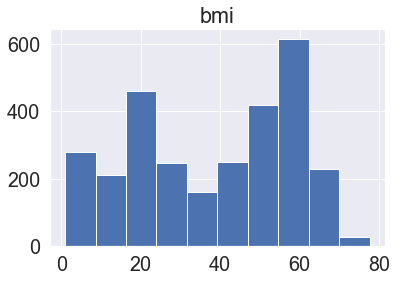

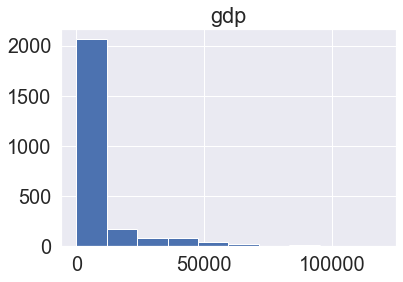

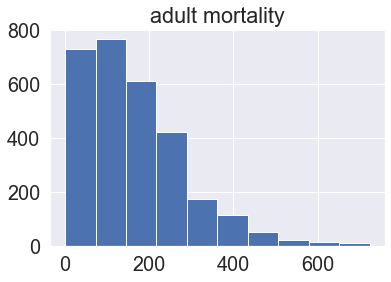

<IPython.core.display.Javascript object>

In [13]:
plt.hist(lifeex_df["bmi"])
plt.title("bmi")
plt.show()

plt.hist(lifeex_df["gdp"])
plt.title("gdp")
plt.show()

plt.hist(lifeex_df["adult mortality"])
plt.title("adult mortality")
plt.show()

My strategy for dealing with these nonsensical values will be to first replace them with np.nan, then try to interpolate using the fact that we have time series data, then see how many values are missing and drop columns for which there is too high of a percentage of missing values, and finally drop all np.nans that are left over for the remaining columns.

In [14]:
lifeex_df["bmi"] = np.where((lifeex_df.bmi < 15), np.nan, lifeex_df.bmi)
lifeex_df["bmi"] = np.where((lifeex_df.bmi > 35), np.nan, lifeex_df.bmi)

<IPython.core.display.Javascript object>

In [15]:
# let's throw out some of the outliers at zero, and take these as non-reported
lifeex_df["schooling"] = np.where(
    (lifeex_df.schooling == 0), np.nan, lifeex_df.schooling
)
lifeex_df["income composition of resources"] = np.where(
    (lifeex_df["income composition of resources"] == 0),
    np.nan,
    lifeex_df["income composition of resources"],
)

<IPython.core.display.Javascript object>

In [16]:
lifeex_df["gdp"] = np.where((lifeex_df.gdp < 200), np.nan, lifeex_df.gdp)
lifeex_df["adult mortality"] = np.where(
    (lifeex_df["adult mortality"] < 50), np.nan, lifeex_df["adult mortality"]
)

<IPython.core.display.Javascript object>

In [17]:
lifeex_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928 entries, 0 to 2937
Data columns (total 15 columns):
country                            2928 non-null object
year                               2928 non-null int64
life expectancy                    2928 non-null float64
adult mortality                    2420 non-null float64
alcohol                            2735 non-null float64
bmi                                858 non-null float64
polio                              2909 non-null float64
diphtheria                         2909 non-null float64
hiv/aids                           2928 non-null float64
gdp                                2181 non-null float64
thinness  1-19 years               2896 non-null float64
thinness 5-9 years                 2896 non-null float64
income composition of resources    2638 non-null float64
schooling                          2742 non-null float64
is_devel                           2928 non-null int64
dtypes: float64(12), int64(2), object(1)
mem

<IPython.core.display.Javascript object>

bmi is now missing too frequently, going to drop this column entirely.

In [18]:
lifeex_df = lifeex_df.drop(columns=["bmi"])

<IPython.core.display.Javascript object>

In [19]:
df = lifeex_df.copy()

cols = [col for col in df.columns if col not in ["country", "year"]]

countries = df["country"].unique()

# interpolate within states
for country in countries:
    df.loc[df["country"] == country, cols] = df.loc[df["country"] == country, cols].interpolate(limit_direction="both")


<IPython.core.display.Javascript object>

In [20]:
# dropping year
df = df.drop(columns=["year"])

df.describe()

,life expectancy,adult mortality,alcohol,polio,diphtheria,hiv/aids,gdp,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling,is_devel
count,2928.000000,2928.000000,2912.000000,2928.000000,2928.000000,2928.000000,2528.000000,2896.000000,2896.000000,2768.000000,2768.000000,2928.000000
mean,69.224932,193.709187,4.529336,82.304986,82.071721,1.747712,7555.154716,4.850622,4.881423,0.654804,12.087139,0.174863
std,9.523867,113.225668,4.069174,23.626164,23.907556,5.085542,14150.365927,4.420829,4.509609,0.162136,3.172502,0.379915
min,36.300000,51.000000,0.010000,3.000000,2.000000,0.100000,212.584798,0.100000,0.100000,0.253000,2.800000,0.000000
25%,63.100000,112.000000,0.657500,77.000000,78.000000,0.100000,648.227230,1.600000,1.575000,0.519000,10.175000,0.000000
50%,72.100000,165.000000,3.630000,93.000000,93.000000,0.100000,1860.428571,3.300000,3.400000,0.683500,12.400000,0.000000
75%,75.700000,251.000000,7.640000,97.000000,97.000000,0.800000,6136.865491,7.200000,7.200000,0.779250,14.300000,0.000000
max,89.000000,723.000000,17.870000,99.000000,99.000000,50.600000,119172.741800,27.700000,28.600000,0.948000,20.700000,1.000000


<IPython.core.display.Javascript object>

### 3. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

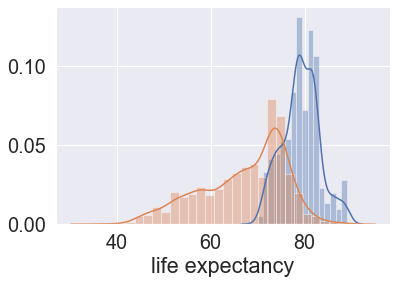

<IPython.core.display.Javascript object>

In [21]:
#investigating the effects of development on life expectancy
sns.distplot(df['life expectancy'].loc[df['is_devel'] ==1]
            )

sns.distplot(df['life expectancy'].loc[df['is_devel'] ==0]
            )

plt.show()


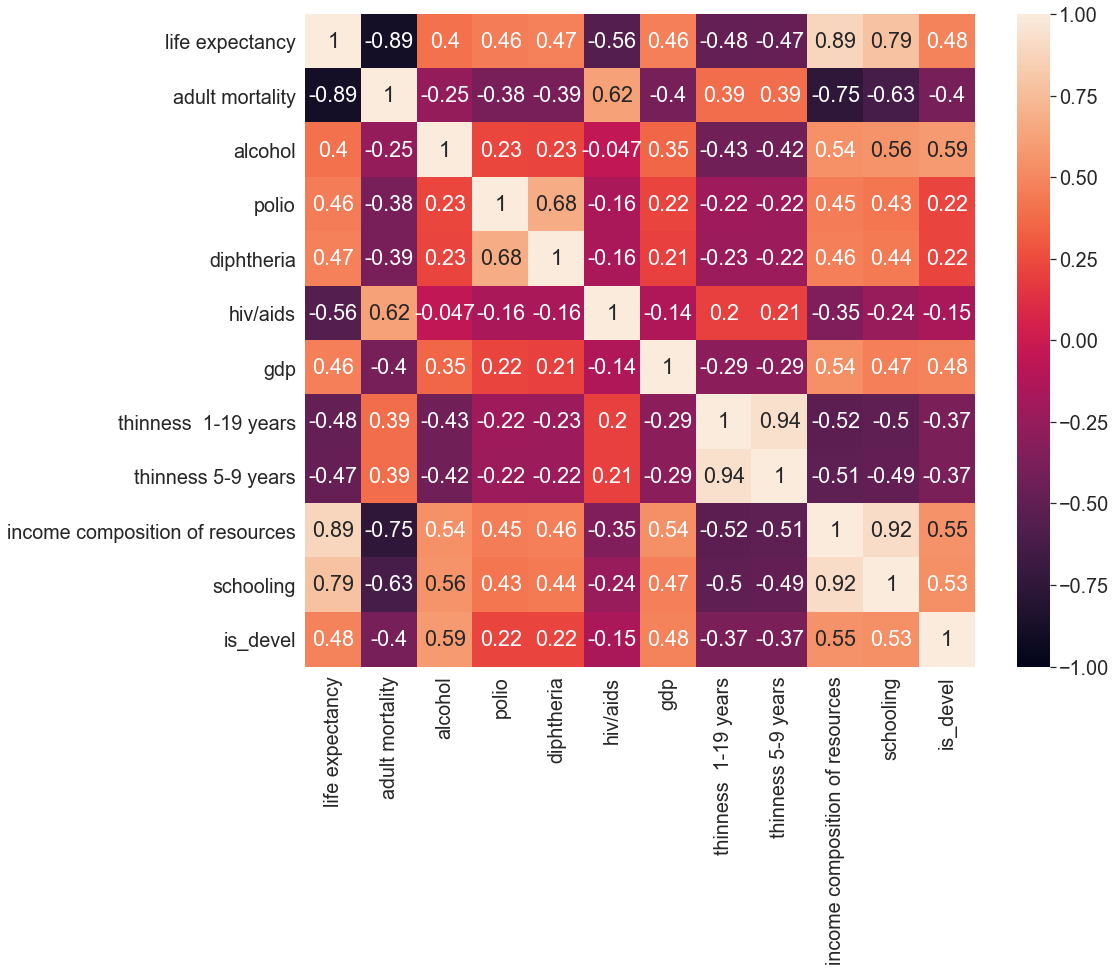

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

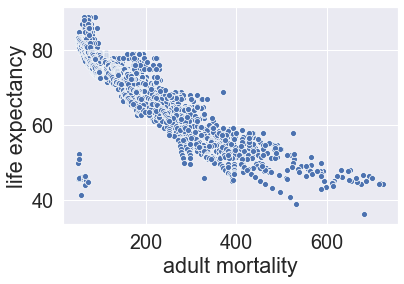

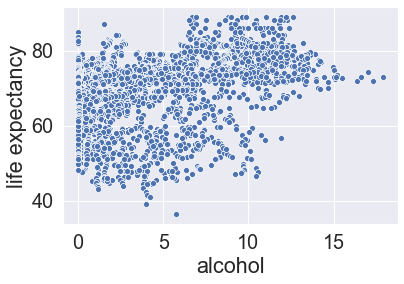

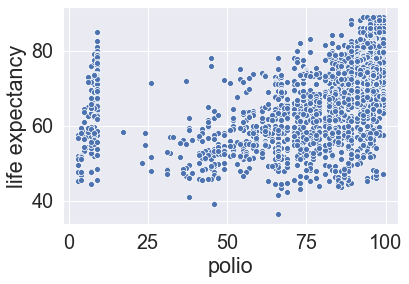

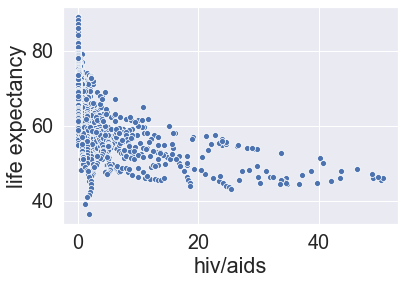

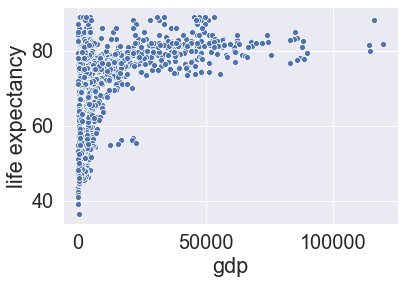

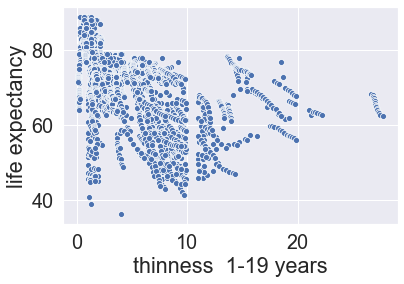

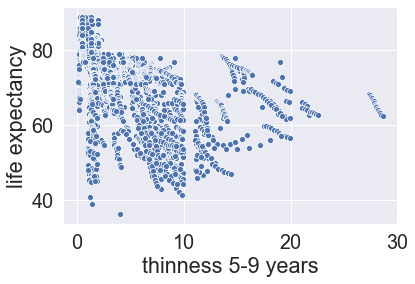

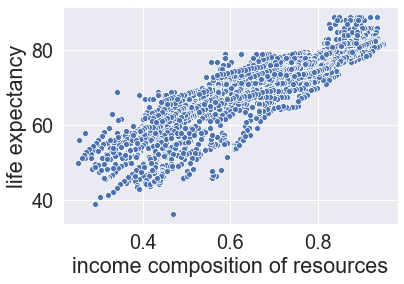

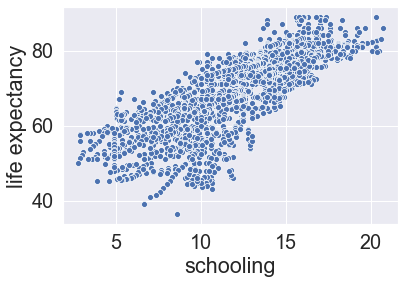

<IPython.core.display.Javascript object>

In [23]:
sns.scatterplot(df['adult mortality'],df['life expectancy'])
plt.show()

sns.scatterplot(df['alcohol'],df['life expectancy'])
plt.show()

sns.scatterplot(df['polio'],df['life expectancy'])
plt.show()

sns.scatterplot(df['hiv/aids'],df['life expectancy'])
plt.show()
sns.scatterplot(df['gdp'],df['life expectancy'])
plt.show()
sns.scatterplot(df['thinness  1-19 years'],df['life expectancy'])
plt.show()
sns.scatterplot(df['thinness 5-9 years'],df['life expectancy'])
plt.show()
sns.scatterplot(df['income composition of resources'],df['life expectancy'])
plt.show()
sns.scatterplot(df['schooling'],df['life expectancy'])
plt.show()


### 4. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.


The most highly correlated variable is adult mortality, but feature seems too closely related to the target variable, and therefore might not be relevant to modeling if the goal is to search for causation.  The two standout features that seem to be correlated the most with life expectancy are schooling and income composition of resources. 

### 5. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization

In summary, this dataset contains a LOT of nonsensical data and should be taken with many pounds of salt.  In order to really extract meaning from it, I would need more information about the missing values as well as the nonsensical ones that are riddled throughout.

After having dealt as well as possible with the missing and flawed values, I conclude that the two most tightly correlated features with life expectancy are schooling and income composition of resources.